# Data Ingestion 
This notebook details the initial development of the data ingestion scripts

Notes
------
- The vehicle id and timestamp can be used together as the unique id
- Before loading feed entity it should be check that the most recent timestamp for vehicle should not be repeated. 

## Packages

In [91]:
import os 
from google.transit import gtfs_realtime_pb2
import requests
from time import sleep
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from typing import Optional, List

## Functions

In [ ]:
def fetch_gtfs_data(url: str) -> bytes | None:
    """
    Fetch GTFS real-time data from the given URL.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        return None

def parse_gtfs_data(data: bytes) -> gtfs_realtime_pb2.FeedMessage | None:
    """
    Parse GTFS real-time data from bytes.
    """
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(data)
    return feed

def get_field(obj, field):
    return getattr(obj, field, None) 

def get_dict_from_feed(header, entity) -> dict:
    """
    Convert a FeedEntity to a dictionary, handling missing fields gracefully.

    Parameters:
    -----------
    header: gtfs_realtime_pb2.FeedHeader
        The FeedHeader containing metadata about the feed.
        
    entity: gtfs_realtime_pb2.FeedEntity
        The FeedEntity to convert.

    Returns
    -------
    dict
        A dictionary representation of the FeedEntity.
    """
    vehicle = get_field(entity, "vehicle")
    trip = get_field(vehicle, "trip") 
    position = get_field(vehicle, "position")
    vehicle_info = get_field(vehicle, "vehicle")

    return {
        "feed_timestamp": get_field(header, "timestamp"),
        "entity_id": get_field(entity, "id"),
        "trip_id": get_field(trip, "trip_id"),
        "trip_start_time": get_field(trip, "start_time"),
        "trip_start_date": get_field(trip, "start_date"),
        "trip_schedule_relationship": get_field(trip, "schedule_relationship"),
        "trip_route_id": get_field(trip, "route_id"),
        "trip_direction_id": get_field(trip, "direction_id"),
        "position_latitude": get_field(position, "latitude"),
        "position_longitude": get_field(position, "longitude"),
        "position_bearing": get_field(position, "bearing"),
        "position_odometer": get_field(position, "odometer"),
        "position_speed": get_field(position, "speed"),
        "current_stop_sequence": get_field(vehicle, "current_stop_sequence"),
        "current_status": get_field(vehicle, "current_status"),
        "timestamp": get_field(vehicle, "timestamp"),
        "congestion_level": get_field(vehicle, "congestion_level"),
        "stop_id": get_field(vehicle, "stop_id"),
        "vehicle_id": get_field(vehicle_info, "id"),
        "vehicle_label": get_field(vehicle_info, "label"),
    }
def extract_feed_info(feed: gtfs_realtime_pb2.FeedEntity) -> List[dict]:
    """
    Convert a FeedEntity to a dictionary, handling missing fields gracefully.

    Parameters:
    -----------
    feed: gtfs_realtime_pb2.Feed
        The Feed to convert.

    Returns
    -------
    List[dict]
        A list of dictionary representations of the FeedEntities.
    """
    header = get_field(feed, "header")
    list_entity = get_field(feed, "entity")
    list_dict_entities = [get_dict_from_feed(header, entity) for entity in list_entity]

    return list_dict_entities

def get_df_feed(list_dict_entities: List[dict], vehicle_current_timestamp: dict) -> pd.DataFrame:
    """
    Convert a list of dictionary representations of FeedEntities to a DataFrame.

    Parameters:
    -----------
    list_dict_entities: List[dict]
        A list of dictionary representations of the FeedEntities.

    vehicle_current_timestamp: dict
        A dictionary mapping vehicle IDs to their latest timestamps.

    Returns
    -------
    df_feed: pd.DataFrame
        A DataFrame representation of the FeedEntities.

    vehicle_current_timestamp: dict
        A dictionary mapping vehicle IDs to their latest timestamps.
    """
    list_non_duplicates = []
    for dict_entity in list_dict_entities:
        vehicle_id = dict_entity['vehicle_id']
        cond = vehicle_id not in vehicle_current_timestamp
        cond |= (vehicle_id in vehicle_current_timestamp and\
                 dict_entity['timestamp'] > vehicle_current_timestamp[vehicle_id])
        if cond:
            list_non_duplicates.append(dict_entity)
            vehicle_current_timestamp[vehicle_id] = dict_entity['timestamp']

    df_feed = pd.DataFrame(list_non_duplicates)
    return df_feed, vehicle_current_timestamp

def format_data(df_feed: pd.DataFrame) -> pd.DataFrame:
    """
    Format the DataFrame by converting timestamp columns to datetime.

    Parameters
    ----------
    df_feed: pd.DataFrame
        The DataFrame to format.

    Returns
    -------
    pd.DataFrame
        The formatted DataFrame.
    """
    df_feed['feed_timestamp'] = pd.to_datetime(df_feed['feed_timestamp'], unit='ms')
    df_feed['timestamp'] = pd.to_datetime(df_feed['timestamp'], unit='ms')
    return df_feed

## Constants

In [142]:
realtime_vehicle_updates_url = "https://bct.tmix.se/gtfs-realtime/vehicleupdates.pb?operatorIds=47"

root_dir = os.path.dirname(os.path.abspath("."))  # Fixed typo from dirname to dir
data_dir = os.path.join(root_dir, "data")
src_dir = os.path.join(root_dir, "src")
os.makedirs(data_dir, exist_ok=True)

df_path = os.path.join(data_dir, "vehicle_updates.csv")


# script parameter 
download = True

## Get Feed

In [159]:
if download:
    df = pd.DataFrame()
    vehicle_current_timestamp = {}
    for i in range(200):
        data = fetch_gtfs_data(realtime_vehicle_updates_url)
        if data:
            feed = parse_gtfs_data(data)
            list_dict_entities = extract_feed_info(feed)
            print(f"Feed has {len(feed.entity)} entities.")
            df_feed, vehicle_current_timestamp = get_df_feed(
                list_dict_entities, vehicle_current_timestamp)
            if not df_feed.empty:
                df_feed = format_data(df_feed)
                df = pd.concat([df, df_feed], ignore_index=True)
        sleep(1)
    df.to_csv(df_path, index=False)
else:
    df = pd.read_csv(df_path)

Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 23 entities.
Feed has 2

## Plots

In [164]:
df_bus = df[(df['trip_route_id']=='8-KEL') & (df['vehicle_id']=='3131326020')]

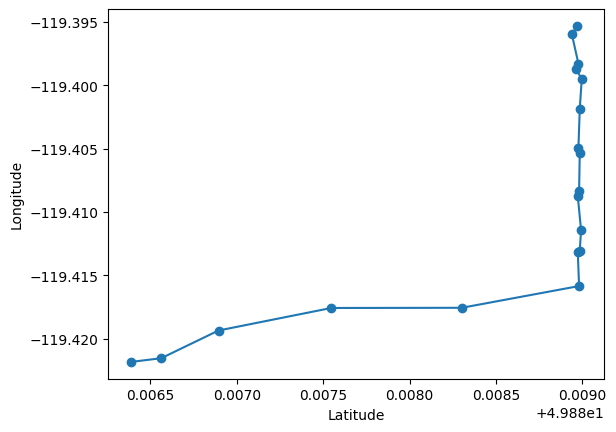

In [166]:
plt.plot(df_bus['position_latitude'], df_bus['position_longitude'], marker='o', linestyle='-')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()